# Firecrown YAML Interface

Following the tutorials from the firecrown team [here](https://firecrown.readthedocs.io/en/latest/_static/inferred_zdist.html), 
this notebook tests the creation of firecrown data-vectors and likelihoods using the YAML interface.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from firecrown.metadata_types import Galaxies, InferredGalaxyZDist
from firecrown.generators.inferred_galaxy_zdist import ZDistLSSTSRDBin, LinearGrid1D
from firecrown.utils import base_model_to_yaml, base_model_from_yaml

import numpy as np
import matplotlib.pyplot as plt
import importlib

## Creating a inferred galaxy redshift distribution data-vector

First let's create these objects and then convert them to YAML files

In [2]:
z = LinearGrid1D(start=0.01, end=0.5, num=50)
bin0 = ZDistLSSTSRDBin(
    zpl=0.1,
    zpu=0.2,
    sigma_z=0.03,
    z=z,
    bin_name="bin0",
    measurements={Galaxies.COUNTS},
)

bin0_yaml = base_model_to_yaml(bin0)
print(bin0_yaml)

zpl: 0.1
zpu: 0.2
sigma_z: 0.03
z:
  start: 0.01
  end: 0.5
  num: 50
bin_name: bin0
measurements:
- subject: Galaxies
  property: COUNTS



Or maybe we need to create a collection for it to work?

In [3]:
from firecrown.generators.inferred_galaxy_zdist import ZDistLSSTSRDBinCollection

In [4]:
bin_collect = ZDistLSSTSRDBinCollection(
    alpha=0.1,
    beta=0.2,
    z0=0.3,
    bins=[bin0],
    )

In [5]:
zdist = bin_collect.generate()

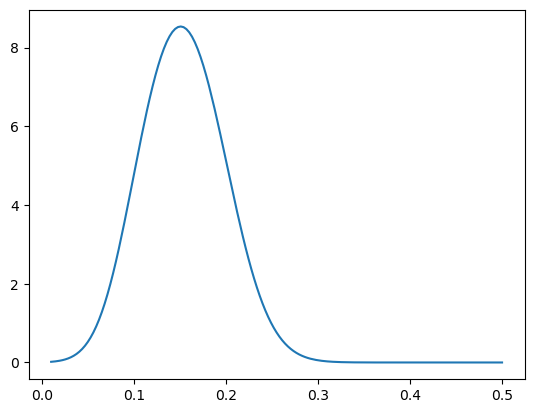

In [6]:
plt.plot(zdist[0].z, zdist[0].dndz)

In [7]:
import sys
from pathlib import Path

# Add the CosmoAPI directory to the Python path
sys.path.append("../CosmoAPI")

# Import the load_nz function
from two_point_functions.nz_loader import 

# Example usage
yaml_data = {
    "nz_type": "LSST_Y10_SOURCE_BIN_COLLECTION"
}
result = load_nz(yaml_data)

#print(result)

SyntaxError: invalid syntax (1840466586.py, line 8)

# 2pt functions playground

## Generating the metadata

In [8]:
from firecrown.generators.inferred_galaxy_zdist import (
    LSST_Y1_LENS_BIN_COLLECTION,
    LSST_Y1_SOURCE_BIN_COLLECTION,
)

count_bins = LSST_Y1_LENS_BIN_COLLECTION.generate()
shear_bins = LSST_Y1_SOURCE_BIN_COLLECTION.generate()
all_y1_bins = count_bins + shear_bins

In [9]:
import numpy as np
from firecrown.metadata_functions import make_all_photoz_bin_combinations, TwoPointHarmonic, TwoPointReal

all_two_point_xy = make_all_photoz_bin_combinations(all_y1_bins)
ells = np.unique(np.geomspace(2, 2000, 128).astype(int))
all_two_point_cells = [TwoPointHarmonic(XY=xy, ells=ells) for xy in all_two_point_xy]
all_two_point_xis = [TwoPointReal(XY=xy, thetas=np.geomspace(0.1, 10, 128)) for xy in all_two_point_xy]

ValueError: Measurements Galaxies.COUNTS and Galaxies.SHEAR_E must support real-space calculations.

In [10]:
all_two_point_xy[0]

TwoPointXY(x=InferredGalaxyZDist(bin_name='lens_0.2_0.4_y1', z=array([0.00000000e+00, 8.54492187e-05, 1.70898437e-04, 2.56347656e-04,
       3.41796875e-04, 5.12695312e-04, 6.83593750e-04, 8.54492187e-04,
       1.02539062e-03, 1.19628906e-03, 1.36718750e-03, 1.70898437e-03,
       2.05078125e-03, 2.39257812e-03, 2.73437500e-03, 3.07617187e-03,
       3.41796875e-03, 3.75976562e-03, 4.10156250e-03, 4.44335937e-03,
       4.78515625e-03, 5.12695312e-03, 5.46875000e-03, 5.81054687e-03,
       6.15234375e-03, 6.49414062e-03, 6.83593750e-03, 7.17773437e-03,
       7.51953125e-03, 7.86132812e-03, 8.20312500e-03, 8.54492187e-03,
       8.88671875e-03, 9.22851562e-03, 9.57031250e-03, 9.91210937e-03,
       1.02539062e-02, 1.05957031e-02, 1.09375000e-02, 1.12792969e-02,
       1.16210937e-02, 1.19628906e-02, 1.23046875e-02, 1.26464844e-02,
       1.29882812e-02, 1.33300781e-02, 1.36718750e-02, 1.43554687e-02,
       1.50390625e-02, 1.57226562e-02, 1.64062500e-02, 1.70898437e-02,
       1.77734

## Defining the 2pt factories

In [11]:
import firecrown.likelihood.weak_lensing as wl
import firecrown.likelihood.number_counts as nc
import firecrown.likelihood.two_point as tp

# WeakLensing systematics -- global
ia_systematic = wl.LinearAlignmentSystematicFactory()
# WeakLensing systematics -- per-bin
wl_photoz = wl.PhotoZShiftFactory()
wl_mult_bias = wl.MultiplicativeShearBiasFactory()

# NumberCounts systematics -- global
# As for Firecrown 1.8.0a0, we do not have any global systematics for number counts
# NumberCounts systematics -- per-bin
nc_photoz = nc.PhotoZShiftFactory()

wlf = wl.WeakLensingFactory(
    per_bin_systematics=[wl_mult_bias, wl_photoz],
    global_systematics=[ia_systematic],
)
ncf = nc.NumberCountsFactory(
    per_bin_systematics=[nc_photoz],
    global_systematics=[],
)

In [12]:
all_two_point_functions = tp.TwoPoint.from_metadata(
    metadata_seq=all_two_point_cells,
    wl_factory=wlf,
    nc_factory=ncf,
)

In [13]:
test_wlf = base_model_to_yaml(wlf)
print(type(test_wlf))

<class 'str'>


## loading factories from yaml

In [14]:
import yaml
def load_yaml_file(file_path):
    """Helper function to load a YAML file"""
    with open(file_path, 'r') as file:
        return yaml.safe_load(file)

In [15]:
config = load_yaml_file("../test.yaml")
probes = config.get("probes", [])

In [16]:
nzs = []
for probe, propr in config['probes'].items():
    if 'nz_type' in propr:
        print(propr['nz_type'])
        nzs += load_nz(propr)

LSST_Y1_SOURCE_BIN_COLLECTION


NameError: name 'load_nz' is not defined

In [16]:
def load_systematics_factory(probe_systematics):
    """
    Dynamically load a class based on the systematics 'type' specified in the YAML file.

    Args:
        systematics_type (str): The 'type' field from the YAML specifying which factory to use.

    Returns:
        The loaded class from the firecrown library.
    """
    # Define base module path based on firecrown's library structure
    base_module = "firecrown.likelihood"
    
    # Mapping of known factories to their submodules
    type_to_submodule = {
        'WeakLensingFactory': 'weak_lensing',
        'NumberCountsFactory': 'number_counts',
        # Add other mappings as needed, or consider an automatic lookup if patterns are consistent
    }

    systematics_type = probe_systematics['type']
    # Get the submodule for the type
    submodule = type_to_submodule.get(systematics_type)
    
    if submodule is None:
        raise ImportError(f"Unknown systematics type: {systematics_type}")
    
    # Construct the full module path
    module_path = f"{base_module}.{submodule}"
    
    try:
        # Dynamically import the module
        module = importlib.import_module(module_path)
        # Get the class from the module
        factory_class = getattr(module, systematics_type)
        # copy the systematics dictionary
        systematics_yaml = probe_systematics.copy()
        # remove the type key
        del systematics_yaml['type']
        # instantiate the factory
        factory = base_model_from_yaml(factory_class, yaml.dump(systematics_yaml))
        return factory
    except ImportError as e:
        raise ImportError(f"Could not import module {module_path}: {e}")
    except AttributeError as e:
        raise AttributeError(f"Class '{systematics_type}' not found in module {module_path}: {e}")

In [17]:
def load_function_class(function_name):
    """
    Dynamically load a class based on the 'function' name specified in the YAML file.

    Args:
        function_name (str): The name of the function specified in the YAML.

    Returns:
        The loaded class based on the function name.
    """
    # Assume functions are part of a module like 'firecrown.functions'
    base_module = "firecrown.metadata_functions"
    
    try:
        # Dynamically import the module
        module = importlib.import_module(base_module)
        # Get the function class from the module
        function_class = getattr(module, function_name)
        return function_class
    except ImportError as e:
        raise ImportError(f"Could not import module {base_module}: {e}")
    except AttributeError as e:
        raise AttributeError(f"Class '{function_name}' not found in module {base_module}: {e}")

def process_probes(yaml_data):
    """
    Process the probes from the YAML data, check if 'function' is the same across probes with 'nz_type',
    and dynamically load the corresponding function classes.

    Args:
        yaml_data (dict): Parsed YAML data in dictionary format.

    Returns:
        A dictionary containing the dynamically loaded function classes for each probe.
    """
    probes_data = yaml_data.get('probes', {})
    
    # Variables to track the function consistency
    nz_type_probes = []
    function_name = None
    
    function_classes = {}
    
    # Iterate over each probe in the YAML data
    for probe_name, probe_data in probes_data.items():
        nz_type = probe_data.get('nz_type')
        probe_function = probe_data.get('function')
        
        # If the probe has 'nz_type', we need to check the function
        if nz_type:
            nz_type_probes.append(probe_name)
            
            # If it's the first nz_type probe, set the expected function name
            if function_name is None:
                function_name = probe_function
            else:
                # If another nz_type probe has a different function, raise an error
                if probe_function != function_name:
                    raise ValueError(f"Probes '{nz_type_probes[0]}' and '{probe_name}' have different 'function' values: '{function_name}' != '{probe_function}'")
            
            # Dynamically load the function class
            if probe_function:
                try:
                    loaded_function = load_function_class(probe_function)
                    function_classes[probe_name] = loaded_function
                except (ImportError, AttributeError) as e:
                    raise ImportError(f"Error loading function for probe '{probe_name}': {e}")
    
    # If nz_type_probes is non-empty, it confirms nz_type presence and function consistency
    if nz_type_probes:
        print(f"All nz_type probes have the same function: {function_name}")

    return loaded_function


In [18]:
two_pt_function = process_probes(config)

All nz_type probes have the same function: TwoPointHarmonic


In [19]:
for p in probes:
    probes[p]['loaded_systematics'] = load_systematics_factory(probes[p]['systematics'])
    

In [40]:
#FIXME: We have to implement this in the yaml
#ells = np.unique(np.geomspace(2, 2000, 128).astype(int))

# trying from the firecrown example:
from firecrown.generators.two_point import LogLinearElls

ells_generator = LogLinearElls(minimum=2, midpoint=199, maximum=200, n_log=20)


[  2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18  19
  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37
  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55
  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73
  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109
 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127
 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145
 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163
 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181
 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199
 200]
minimum: 2
midpoint: 199
maximum: 200
n_log: 20



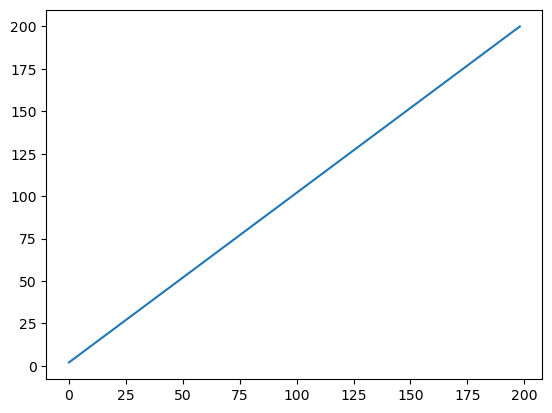

In [41]:
ells_yamls = base_model_to_yaml(ells_generator)
ells = ells_generator.generate()
print(ells)
print(ells_yamls)

plt.plot(ells)

In [21]:
all_two_point_bins = make_all_photoz_bin_combinations(nzs)

In [22]:
all_two_point_metdata = [two_pt_function(XY=ij, ells=ells) for ij in all_two_point_bins]

In [23]:
import pandas as pd
from IPython.display import Markdown

two_point_names = [
    (Cells.XY.x.bin_name, Cells.XY.y.bin_name, Cells.get_sacc_name())
    for Cells in all_two_point_metdata
]
df = pd.DataFrame(two_point_names, columns=["bin-x", "bin-y", "SACC data-type"])
Markdown(df.to_markdown())

|    | bin-x             | bin-y             | SACC data-type           |
|---:|:------------------|:------------------|:-------------------------|
|  0 | source_0.2_0.4_y1 | source_0.2_0.4_y1 | galaxy_shear_cl_ee       |
|  1 | source_0.2_0.4_y1 | source_0.4_0.6_y1 | galaxy_shear_cl_ee       |
|  2 | source_0.2_0.4_y1 | source_0.6_0.8_y1 | galaxy_shear_cl_ee       |
|  3 | source_0.2_0.4_y1 | source_0.8_1.0_y1 | galaxy_shear_cl_ee       |
|  4 | source_0.2_0.4_y1 | source_1.0_1.2_y1 | galaxy_shear_cl_ee       |
|  5 | source_0.2_0.4_y1 | lens_0.2_0.4_y1   | galaxy_shearDensity_cl_e |
|  6 | source_0.2_0.4_y1 | lens_0.4_0.6_y1   | galaxy_shearDensity_cl_e |
|  7 | source_0.2_0.4_y1 | lens_0.6_0.8_y1   | galaxy_shearDensity_cl_e |
|  8 | source_0.2_0.4_y1 | lens_0.8_1.0_y1   | galaxy_shearDensity_cl_e |
|  9 | source_0.2_0.4_y1 | lens_1.0_1.2_y1   | galaxy_shearDensity_cl_e |
| 10 | source_0.4_0.6_y1 | source_0.4_0.6_y1 | galaxy_shear_cl_ee       |
| 11 | source_0.4_0.6_y1 | source_0.6_0.8_y1 | galaxy_shear_cl_ee       |
| 12 | source_0.4_0.6_y1 | source_0.8_1.0_y1 | galaxy_shear_cl_ee       |
| 13 | source_0.4_0.6_y1 | source_1.0_1.2_y1 | galaxy_shear_cl_ee       |
| 14 | source_0.4_0.6_y1 | lens_0.2_0.4_y1   | galaxy_shearDensity_cl_e |
| 15 | source_0.4_0.6_y1 | lens_0.4_0.6_y1   | galaxy_shearDensity_cl_e |
| 16 | source_0.4_0.6_y1 | lens_0.6_0.8_y1   | galaxy_shearDensity_cl_e |
| 17 | source_0.4_0.6_y1 | lens_0.8_1.0_y1   | galaxy_shearDensity_cl_e |
| 18 | source_0.4_0.6_y1 | lens_1.0_1.2_y1   | galaxy_shearDensity_cl_e |
| 19 | source_0.6_0.8_y1 | source_0.6_0.8_y1 | galaxy_shear_cl_ee       |
| 20 | source_0.6_0.8_y1 | source_0.8_1.0_y1 | galaxy_shear_cl_ee       |
| 21 | source_0.6_0.8_y1 | source_1.0_1.2_y1 | galaxy_shear_cl_ee       |
| 22 | source_0.6_0.8_y1 | lens_0.2_0.4_y1   | galaxy_shearDensity_cl_e |
| 23 | source_0.6_0.8_y1 | lens_0.4_0.6_y1   | galaxy_shearDensity_cl_e |
| 24 | source_0.6_0.8_y1 | lens_0.6_0.8_y1   | galaxy_shearDensity_cl_e |
| 25 | source_0.6_0.8_y1 | lens_0.8_1.0_y1   | galaxy_shearDensity_cl_e |
| 26 | source_0.6_0.8_y1 | lens_1.0_1.2_y1   | galaxy_shearDensity_cl_e |
| 27 | source_0.8_1.0_y1 | source_0.8_1.0_y1 | galaxy_shear_cl_ee       |
| 28 | source_0.8_1.0_y1 | source_1.0_1.2_y1 | galaxy_shear_cl_ee       |
| 29 | source_0.8_1.0_y1 | lens_0.2_0.4_y1   | galaxy_shearDensity_cl_e |
| 30 | source_0.8_1.0_y1 | lens_0.4_0.6_y1   | galaxy_shearDensity_cl_e |
| 31 | source_0.8_1.0_y1 | lens_0.6_0.8_y1   | galaxy_shearDensity_cl_e |
| 32 | source_0.8_1.0_y1 | lens_0.8_1.0_y1   | galaxy_shearDensity_cl_e |
| 33 | source_0.8_1.0_y1 | lens_1.0_1.2_y1   | galaxy_shearDensity_cl_e |
| 34 | source_1.0_1.2_y1 | source_1.0_1.2_y1 | galaxy_shear_cl_ee       |
| 35 | source_1.0_1.2_y1 | lens_0.2_0.4_y1   | galaxy_shearDensity_cl_e |
| 36 | source_1.0_1.2_y1 | lens_0.4_0.6_y1   | galaxy_shearDensity_cl_e |
| 37 | source_1.0_1.2_y1 | lens_0.6_0.8_y1   | galaxy_shearDensity_cl_e |
| 38 | source_1.0_1.2_y1 | lens_0.8_1.0_y1   | galaxy_shearDensity_cl_e |
| 39 | source_1.0_1.2_y1 | lens_1.0_1.2_y1   | galaxy_shearDensity_cl_e |
| 40 | lens_0.2_0.4_y1   | lens_0.2_0.4_y1   | galaxy_density_cl        |
| 41 | lens_0.2_0.4_y1   | lens_0.4_0.6_y1   | galaxy_density_cl        |
| 42 | lens_0.2_0.4_y1   | lens_0.6_0.8_y1   | galaxy_density_cl        |
| 43 | lens_0.2_0.4_y1   | lens_0.8_1.0_y1   | galaxy_density_cl        |
| 44 | lens_0.2_0.4_y1   | lens_1.0_1.2_y1   | galaxy_density_cl        |
| 45 | lens_0.4_0.6_y1   | lens_0.4_0.6_y1   | galaxy_density_cl        |
| 46 | lens_0.4_0.6_y1   | lens_0.6_0.8_y1   | galaxy_density_cl        |
| 47 | lens_0.4_0.6_y1   | lens_0.8_1.0_y1   | galaxy_density_cl        |
| 48 | lens_0.4_0.6_y1   | lens_1.0_1.2_y1   | galaxy_density_cl        |
| 49 | lens_0.6_0.8_y1   | lens_0.6_0.8_y1   | galaxy_density_cl        |
| 50 | lens_0.6_0.8_y1   | lens_0.8_1.0_y1   | galaxy_density_cl        |
| 51 | lens_0.6_0.8_y1   | lens_1.0_1.2_y1   | galaxy_density_cl        |
| 52 | lens_0.8_1.0_y1   | lens_0.8_1.0_y1   | galaxy_density_cl        |
| 53 | lens_0.8_1.0_y1   | lens_1.0_1.2_y1   | galaxy_density_cl        |
| 54 | lens_1.0_1.2_y1   | lens_1.0_1.2_y1   | galaxy_density_cl        |

In [24]:
import firecrown.likelihood.two_point as tp
all_two_point_functions = tp.TwoPoint.from_metadata(
    metadata_seq=all_two_point_metdata,
    wl_factory=probes['source']['loaded_systematics'],
    nc_factory=probes['lens']['loaded_systematics'],
)

In [25]:
from firecrown.parameters import ParamsMap

req_params = all_two_point_functions.required_parameters()
default_values = req_params.get_default_values()
params = ParamsMap(default_values)

In [26]:
default_values

{'source_1.0_1.2_y1_mult_bias': 1.0,
 'lens_0.2_0.4_y1_bias': 1.5,
 'lens_0.4_0.6_y1_delta_z': 0.0,
 'source_1.0_1.2_y1_delta_z': 0.0,
 'source_0.4_0.6_y1_delta_z': 0.0,
 'lens_0.8_1.0_y1_delta_z': 0.0,
 'lens_0.8_1.0_y1_bias': 1.5,
 'source_0.4_0.6_y1_mult_bias': 1.0,
 'source_0.8_1.0_y1_delta_z': 0.0,
 'ia_bias': 0.5,
 'alphaz': 0.0,
 'lens_1.0_1.2_y1_bias': 1.5,
 'lens_0.6_0.8_y1_bias': 1.5,
 'source_0.8_1.0_y1_mult_bias': 1.0,
 'source_0.6_0.8_y1_mult_bias': 1.0,
 'source_0.2_0.4_y1_mult_bias': 1.0,
 'lens_0.2_0.4_y1_delta_z': 0.0,
 'source_0.2_0.4_y1_delta_z': 0.0,
 'lens_0.4_0.6_y1_bias': 1.5,
 'z_piv': 0.5,
 'lens_0.6_0.8_y1_delta_z': 0.0,
 'lens_1.0_1.2_y1_delta_z': 0.0,
 'source_0.6_0.8_y1_delta_z': 0.0}

## Trying to create a likelihood from this

In [27]:
from firecrown.likelihood.gaussian import ConstGaussian

import pyccl

from firecrown.modeling_tools import ModelingTools

ccl_cosmo = pyccl.CosmologyVanillaLCDM()
ccl_cosmo.compute_nonlin_power()

tools = ModelingTools()
tools.update(params)
tools.prepare(ccl_cosmo)

likelihood = ConstGaussian(all_two_point_functions)
likelihood.read(None)
likelihood.update(params)
likelihood.
#likelihood.read(sacc_data)

SyntaxError: invalid syntax (959062734.py, line 17)

In [293]:
likelihood.compute_theory_vector

Signature: likelihood.compute_theory_vector(tools: 'ModelingTools') -> 'npt.NDArray[np.float64]'
Docstring:
Computes the theory vector using the current instance of pyccl.Cosmology.

:param tools: Current ModelingTools object
:return: The computed theory vector
File:      ~/Work/Github/firecrown/firecrown/likelihood/gaussfamily.py
Type:      method